In [57]:
import os
import copy
import pandas as pd
import json

import torch
from torch.utils.data import TensorDataset

# from utils import get_intent_labels, get_slot_labels

<AxesSubplot:xlabel='0'>

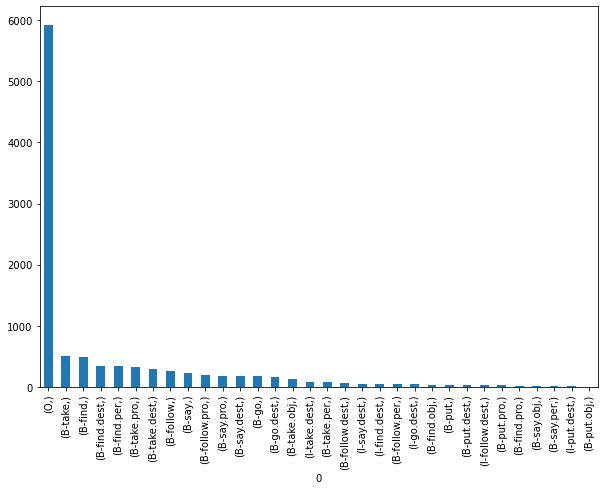

In [64]:
in_path = "./Dataset/dataset_seq_in.txt"

with open(in_path, encoding='utf-8') as f:
    seq_in = [line.rstrip() for line in f if line != '\n' ]


out_path = "./Dataset/dataset_seq_out.txt"

with open(out_path, encoding='utf-8') as f:
    seq_out = [line.rstrip() for line in f if line != '\n']


label_df = pd.DataFrame( x for seq in seq_out for x in seq.split())
# display(label_df.head(5))
label_df.value_counts(subset=None, dropna = True).plot(kind = 'bar', figsize = (10,7))

In [65]:
from sklearn.model_selection import train_test_split


# split the train out of the rest
X_train, X_val_test, Y_train, Y_val_test = train_test_split(seq_in, seq_out, test_size=0.25, random_state=42)

#split the val and test
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.8, random_state=42)

print(f'X_train len: {len(X_train)}')
print(f'Y_train len: {len(Y_train)}\n')

print(f'X_val len: {len(X_val)}')
print(f'Y_val len: {len(Y_val)}\n')

print(f'X_test len: {len(X_test)}')
print(f'Y_test len: {len(Y_test)}\n')


# Write seq files for envs
env_names = {'train':{'X_train':X_train, 'Y_train':Y_train}, 'val':{'X_val':X_val, 'Y_val':Y_val}, 'test':{'X_test':X_test,'Y_test':Y_test}}

def write_seq(env_names):
     for env,data_dict in env_names.items():
        for name,data in data_dict.items():
            path = f'./Dataset/{env}/{name}.txt'
            with open(path, 'w') as f:
                f.write('\n'.join(data))
                
write_seq(env_names)

X_train len: 750
Y_train len: 750

X_val len: 50
Y_val len: 50

X_test len: 200
Y_test len: 200



In [71]:
# val_coun = label_df.value_counts(subset=None, dropna = True)

# intent_label_lst = [label[0] for label in val_coun.index if '.' not in label[0]]
# slot_label_lst = [label[0] for label in val_coun.index if '.' in label[0]]

# print('intent_label_lst: \n',intent_label_lst,'\n')
# print('slot_label_lst: \n',slot_label_lst)

def unique_labels(file_path):
    labels = [line.strip().split() for line in open(file_path, 'r', encoding='utf-8')]
    label_df = pd.Series( x for seq in labels for x in seq)
    return label_df.unique().tolist()


def write_label_file(env):
    path =  f'./Dataset/{env}/Y_{env}.txt'#'./Dataset/' name +'/Y_'+ name +'.txt'
    labels = unique_labels(path)
    
    intent_label_lst = [label for label in labels if '.' not in label and label != 'O']
    slot_label_lst = [label for label in labels if '.' in label or label == 'O']
    
    print('env: ',env)
    print('Unique intents: ',intent_label_lst, len(intent_label_lst))
    print('Unique slots: ',slot_label_lst,len(slot_label_lst),'\n')
    
    intent_path = f'./Dataset/{env}/{env}_intents.txt'
    slot_path = f'./Dataset/{env}/{env}_slots.txt'
    
    with open(intent_path, 'w') as f:
        f.write('\n'.join(intent_label_lst))
        
    with open(slot_path, 'w') as f:
        f.write('\n'.join(slot_label_lst))
    return


for env in env_names.keys():
    write_label_file(env)

env:  train
Unique intents:  ['B-take', 'B-find', 'B-follow', 'B-say', 'B-go', 'B-put'] 6
Unique slots:  ['O', 'B-take.pro', 'B-take.obj', 'B-take.dest', 'I-take.dest', 'B-find.per', 'B-find.dest', 'B-follow.pro', 'B-say.dest', 'B-take.per', 'B-say.pro', 'I-say.dest', 'B-follow.per', 'B-go.dest', 'I-find.dest', 'B-say.per', 'B-follow.dest', 'I-follow.dest', 'B-find.obj', 'I-go.dest', 'B-say.obj', 'B-find.pro', 'B-put.pro', 'B-put.dest', 'I-put.dest'] 25 

env:  val
Unique intents:  ['B-find', 'B-say', 'B-take', 'B-follow', 'B-go'] 5
Unique slots:  ['O', 'B-find.per', 'B-find.dest', 'I-find.dest', 'B-say.pro', 'B-take.dest', 'B-say.dest', 'I-say.dest', 'B-follow.per', 'B-follow.dest', 'B-take.per', 'B-take.pro', 'B-find.pro', 'B-take.obj', 'I-take.dest', 'B-follow.pro', 'B-go.dest', 'I-go.dest'] 18 

env:  test
Unique intents:  ['B-take', 'B-find', 'B-follow', 'B-go', 'B-say', 'B-put'] 6
Unique slots:  ['B-take.per', 'O', 'B-take.dest', 'B-find.per', 'B-find.dest', 'B-follow.pro', 'B-go

In [72]:
def parse_seq(seq_in, seq_out):
    intent_label_lst = [ele for ele in seq_out if ele != 'O' and '.' not in ele]
    command = " ".join(seq_in)
    return {
        'intent_label': intent_label_lst,
        'words': command,
        'words_label': " ".join(seq_out),
        'length': len(seq_in)
    }


def get_dataframe(seq_in,seq_out):
    parsed = [parse_seq(seq_in[i], seq_out[i]) for i in range(len(seq_in))]
    return pd.DataFrame([p for p in parsed if p is not None])

def df_for_envs(env_names):
    envs = env_names.copy()
    for env,name_lst in env_names.items():
        for name in name_lst:
            path = f'./Dataset/{env}/{name}.txt'
            #path = './Dataset/' + name + '.txt'
            with open(path, encoding='utf-8') as f:
                if 'X' in name:
                    seq_in = [line.rstrip().split() for line in f if line != '\n' ]
                elif 'Y' in name:
                    seq_out = [line.rstrip().split() for line in f if line != '\n' ]
                    
        envs.update({env : get_dataframe(seq_in,seq_out)})
    return envs
            
env_names = {'train':['X_train', 'Y_train'], 'val':['X_val', 'Y_val'], 'test':['X_test','Y_test']}
envs = df_for_envs(env_names)


for env,df in envs.items():
    print(env,'\n')
    print('min length: ', min(df['length']))
    print('max length: ', max(df['length']))
    display(df)
    print('------------------------------------------------------------------')

train 

min length:  2
max length:  19


,intent_label,words,words_label,length
0,[B-take],could you please give me the apple from the si...,O O O B-take B-take.pro O B-take.obj O O B-tak...,11
1,"[B-find, B-follow, B-take]",meet francis at the desk follow him and escort...,B-find B-find.per O O B-find.dest B-follow B-f...,11
2,[B-say],say the time to the person pointing to the lef...,B-say O O O O O O O O O O O B-say.dest,13
3,[B-take],take mary from the dishwasher to the couch,B-take B-take.per O O B-take.dest O O O,8
4,[B-say],tell me the gender of the person at the dining...,B-say B-say.pro O O O O O O O B-say.dest I-say...,11
...,...,...,...,...
745,"[B-find, B-follow, B-take]",meet john at the bed follow him and take him back,B-find B-find.per O O B-find.dest B-follow B-f...,11
746,[B-take],take the chocolate drink to the bookcase,B-take O O B-take.obj O O B-take.dest,7
747,[B-say],tell me how many cutlery there are on the dini...,B-say B-say.pro O O B-say.obj O O O O B-say.de...,11
748,[],the living room,O O O,3


------------------------------------------------------------------
val 

min length:  2
max length:  18


,intent_label,words,words_label,length
0,[],could you please the living room,O O O O O O,6
1,"[B-find, B-say]",contact charlie at the dining table and ask hi...,B-find B-find.per O O B-find.dest I-find.dest ...,11
2,[B-take],please deliver drinks to the person raising th...,O B-take O O O O O O O O O O B-take.dest,13
3,[B-say],answer a question to the person raising their ...,B-say O O O O O O O O O O O B-say.dest I-say.dest,14
4,[B-follow],follow robert from the entrance to the corridor,B-follow B-follow.per O O B-follow.dest O O O,8
5,"[B-take, B-find]",take francis to the bed you will find her at t...,B-take B-take.per O O B-take.dest B-take.pro O...,12
6,[B-take],bring the pringles to the storage table,B-take O B-take.obj O O B-take.dest I-take.dest,7
7,"[B-find, B-say]",please find charlie at the rear entrance and i...,O B-find B-find.per O O O B-find.dest O B-say ...,18
8,[B-follow],could you please follow skyler from the bookca...,O O O B-follow B-follow.per O O B-follow.dest ...,11
9,[B-take],take my trolley to the cab,B-take O O O O O,6


------------------------------------------------------------------
test 

min length:  2
max length:  19


,intent_label,words,words_label,length
0,[B-take],guide alex to the dishwasher,B-take B-take.per O O B-take.dest,5
1,"[B-find, B-follow, B-go]",could you please meet patricia at the bed foll...,O O O B-find B-find.per O O B-find.dest B-foll...,15
2,"[B-find, B-take]",contact james at the couch and take him to his...,B-find B-find.per O O B-find.dest O B-take B-t...,11
3,[B-take],give drinks to all the elders in the kitchen,B-take O O O O O O O B-take.dest,9
4,[B-take],please guide charlie to the dishwasher,O B-take B-take.per O O B-take.dest,6
...,...,...,...,...
195,[B-follow],robot please follow alex from the desk to the ...,O O B-follow B-follow.per O O O O O B-follow.dest,10
196,"[B-take, B-take]",could you get the cup from the counter and put...,O O B-take O B-take.obj O O B-take.dest O B-ta...,15
197,"[B-go, B-find, B-say]",robot please go to the bedroom find a person l...,O O B-go O O B-go.dest B-find O O O O O B-say ...,17
198,[B-take],could you please take out the junk,O O O B-take O O O,7


------------------------------------------------------------------


In [73]:
import torch
from transformers import AutoModel, AutoTokenizer, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [74]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, attention_mask, token_type_ids, labels_ids):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        #self.intent_label_id = intent_label_id
        self.labels_ids = labels_ids

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

In [76]:
class JointProcessor(object):
    """Processor for the JointBERT data set """

    def __init__(self, args):
        self.args = args
#         self.intent_labels = get_intent_labels(args)###
        self.labels = get_slot_labels(args)########################################

        self.input_text_file = 'seq.in'
        #self.intent_label_file = 'label'
        self.labels_file = 'seq.out'

    @classmethod
    def _read_file(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            lines = []
            for line in f:
                lines.append(line.strip())
            return lines

    def _create_examples(self, texts, slots, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for i, (text, labels) in enumerate(zip(texts, labels)):
            guid = "%s-%s" % (set_type, i)
            # 1. input_text
            words = text.split()  # Some are spaced twice
#             # 2. intent
#             intent_label = self.intent_labels.index(intent) if intent in self.intent_labels else self.intent_labels.index("UNK")
            # 3. slot
            labels = []
            for s in labels.split():
                labels.append(self.labels.index(s) if s in self.labels else self.labels.index("UNK"))

            assert len(words) == len(labels)
            examples.append(InputExample(guid=guid, words=words, labels=labels))
        return examples

    def get_examples(self, mode):
        """
        Args:
            mode: train, dev, test
        """
        data_path = os.path.join(self.args.data_dir, self.args.task, mode)
        return self._create_examples(texts=self._read_file(os.path.join(data_path, self.input_text_file)),
                                     slots=self._read_file(os.path.join(data_path, self.slot_labels_file)),
                                     set_type=mode)

In [77]:
def convert_examples_to_features(examples, max_seq_len, tokenizer,
                                 pad_token_label_id=-100,
                                 cls_token_segment_id=0,
                                 pad_token_segment_id=0,
                                 sequence_a_segment_id=0,
                                 mask_padding_with_zero=True):
    # Setting based on the current model type
    cls_token = tokenizer.cls_token
    sep_token = tokenizer.sep_token
    unk_token = tokenizer.unk_token
    pad_token_id = tokenizer.pad_token_id

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 5000 == 0:
            logger.info("Writing example %d of %d" % (ex_index, len(examples)))

        # Tokenize word by word (for NER)
        tokens = []
        labels_ids = []
        for word, label in zip(example.words, example.labels):
            word_tokens = tokenizer.tokenize(word)
            if not word_tokens:
                word_tokens = [unk_token]  # For handling the bad-encoded word
            tokens.extend(word_tokens)
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            labels_ids.extend([int(label)] + [pad_token_label_id] * (len(word_tokens) - 1))

        # Account for [CLS] and [SEP]
        special_tokens_count = 2
        if len(tokens) > max_seq_len - special_tokens_count:
            tokens = tokens[:(max_seq_len - special_tokens_count)]
            labels_ids = labels_ids[:(max_seq_len - special_tokens_count)]

        # Add [SEP] token
        tokens += [sep_token]
        labels_ids += [pad_token_label_id]
        token_type_ids = [sequence_a_segment_id] * len(tokens)

        # Add [CLS] token
        tokens = [cls_token] + tokens
        labels_ids = [pad_token_label_id] + labels_ids
        token_type_ids = [cls_token_segment_id] + token_type_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_len - len(input_ids)
        input_ids = input_ids + ([pad_token_id] * padding_length)
        attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
        token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)
        labels_ids = labels_ids + ([pad_token_label_id] * padding_length)

        assert len(input_ids) == max_seq_len, "Error with input length {} vs {}".format(len(input_ids), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_ids) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_ids), max_seq_len)
        assert len(labels_ids) == max_seq_len, "Error with slot labels length {} vs {}".format(len(labels_ids), max_seq_len)

        #intent_label_id = int(example.intent_label)

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % example.guid)
            logger.info("tokens: %s" % " ".join([str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("attention_mask: %s" % " ".join([str(x) for x in attention_mask]))
            logger.info("token_type_ids: %s" % " ".join([str(x) for x in token_type_ids]))
            #logger.info("intent_label: %s (id = %d)" % (example.intent_label, intent_label_id))
            logger.info("slot_labels: %s" % " ".join([str(x) for x in labels_ids]))

        features.append(
            InputFeatures(input_ids=input_ids,
                          attention_mask=attention_mask,
                          token_type_ids=token_type_ids,
                          #intent_label_id=intent_label_id,
                          labels_ids=labels_ids
                          ))

    return features

In [87]:
def load_and_cache_examples(args, tokenizer, mode):
    processor = JointProcessor#processors[args.task](args)

    # Load data features from cache or dataset file
    cached_features_file = os.path.join(
        args.data_dir,
        'cached_{}_{}_{}_{}'.format(
            mode,
            list(filter(None, args.model_name_or_path.split("/"))).pop(),
            args.max_seq_len
        )
    )

    if os.path.exists(cached_features_file):
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
    else:
        # Load data features from dataset file
        logger.info("Creating features from dataset file at %s", args.data_dir)
        if mode == "train":
            examples = processor.get_examples("train")
        elif mode == "dev":
            examples = processor.get_examples("dev")
        elif mode == "test":
            examples = processor.get_examples("test")
        else:
            raise Exception("For mode, Only train, dev, test is available")

        # Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
        pad_token_label_id = args.ignore_index
        features = convert_examples_to_features(examples, args.max_seq_len, tokenizer,
                                                pad_token_label_id=pad_token_label_id)
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    #all_intent_label_ids = torch.tensor([f.intent_label_id for f in features], dtype=torch.long)
    all_labels_ids = torch.tensor([f.labels_ids for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_mask,
                            all_token_type_ids, all_labels_ids)
    return dataset

In [92]:
import argparse


parser = argparse.ArgumentParser()

# parser.add_argument("--task", default=None, required=True, type=str, help="The name of the task to train")
# parser.add_argument("--model_dir", default=None, required=True, type=str, help="Path to save, load model")
parser.add_argument("--data_dir", default="./Dataset", type=str, help="The input data dir")
# parser.add_argument("--intent_label_file", default="intent_label.txt", type=str, help="Intent Label file")
parser.add_argument("--label_file", default="slot_label.txt", type=str, help="Slot Label file")

#parser.add_argument("--model_type", default="bert", type=str, help="Model type selected in the list: " + ", ".join(MODEL_CLASSES.keys()))

parser.add_argument('--seed', type=int, default=1234, help="random seed for initialization")
parser.add_argument("--train_batch_size", default=32, type=int, help="Batch size for training.")
parser.add_argument("--eval_batch_size", default=64, type=int, help="Batch size for evaluation.")
parser.add_argument("--max_seq_len", default=50, type=int, help="The maximum total input sequence length after tokenization.")
parser.add_argument("--learning_rate", default=5e-5, type=float, help="The initial learning rate for Adam.")
parser.add_argument("--num_train_epochs", default=10.0, type=float, help="Total number of training epochs to perform.")
parser.add_argument("--weight_decay", default=0.0, type=float, help="Weight decay if we apply some.")
parser.add_argument('--gradient_accumulation_steps', type=int, default=1,
                    help="Number of updates steps to accumulate before performing a backward/update pass.")
parser.add_argument("--adam_epsilon", default=1e-8, type=float, help="Epsilon for Adam optimizer.")
parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
parser.add_argument("--max_steps", default=-1, type=int, help="If > 0: set total number of training steps to perform. Override num_train_epochs.")
parser.add_argument("--warmup_steps", default=0, type=int, help="Linear warmup over warmup_steps.")
parser.add_argument("--dropout_rate", default=0.1, type=float, help="Dropout for fully-connected layers")

parser.add_argument('--logging_steps', type=int, default=200, help="Log every X updates steps.")
parser.add_argument('--save_steps', type=int, default=200, help="Save checkpoint every X updates steps.")

parser.add_argument("--do_train", action="store_true", help="Whether to run training.")
parser.add_argument("--do_eval", action="store_true", help="Whether to run eval on the test set.")
parser.add_argument("--no_cuda", action="store_true", help="Avoid using CUDA when available")

parser.add_argument("--ignore_index", default=0, type=int,
                    help='Specifies a target value that is ignored and does not contribute to the input gradient')

parser.add_argument('--slot_loss_coef', type=float, default=1.0, help='Coefficient for the slot loss.')


parser.add_argument('-f')

args = parser.parse_args()

args.model_name_or_path = 'bert-base-uncased'#MODEL_PATH_MAP[args.model_type]

print(args)

train_dataset = load_and_cache_examples(args, tokenizer, mode="train")

Namespace(data_dir='./Dataset', label_file='slot_label.txt', seed=1234, train_batch_size=32, eval_batch_size=64, max_seq_len=50, learning_rate=5e-05, num_train_epochs=10.0, weight_decay=0.0, gradient_accumulation_steps=1, adam_epsilon=1e-08, max_grad_norm=1.0, max_steps=-1, warmup_steps=0, dropout_rate=0.1, logging_steps=200, save_steps=200, do_train=False, do_eval=False, no_cuda=False, ignore_index=0, slot_loss_coef=1.0, f='C:\\Users\\wang\\AppData\\Roaming\\jupyter\\runtime\\kernel-712ba379-317a-4522-abc0-458c1fa56bc2.json', model_name_or_path='bert-base-uncased')


IndexError: Replacement index 3 out of range for positional args tuple

In [90]:
%tb

SystemExit: 2